# Quantum Counting Algorithm

The Quantum Counting algorithm, introduced by Brassard, Høyer, and Tapp [1], counts the number of marked items $M$ in an unstructured database of $N = 2^n$ elements. It combines **Grover's search operator** with **Quantum Phase Estimation (QPE)** to achieve a quadratic speedup over classical counting, requiring only $O(\sqrt{N})$ oracle queries instead of the classical $\Theta(N)$.

**Key idea:** The Grover operator $G = D \cdot O$ has eigenvalues $e^{\pm i\theta}$, where $\theta$ satisfies $\sin^2(\theta/2) = M/N$. By applying QPE to $G$, we estimate $\theta$ and hence determine $M$.

## References

[[1] G. Brassard, P. Høyer, and A. Tapp, "Quantum Counting", Proceedings of ICALP 1998](https://arxiv.org/abs/quant-ph/9805082)

[[2] M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, Cambridge University Press, 2010](https://www.cambridge.org/highereducation/books/quantum-computation-and-quantum-information/01E10196D0A682A6AEFFEA52D53BE9AE)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from braket.circuits import Circuit
from braket.devices import LocalSimulator

from braket.experimental.algorithms.quantum_counting import (
    build_grover_matrix,
    build_oracle_matrix,
    get_quantum_counting_results,
    quantum_counting_circuit,
    run_quantum_counting,
)

%matplotlib inline

## Background

### The Grover Operator

Given an oracle $O$ that marks certain states by flipping their phase ($O|x\rangle = (-1)^{f(x)}|x\rangle$), and the Grover diffusion operator $D = 2|s\rangle\langle s| - I$, the Grover operator is:

$$G = D \cdot O$$

In the 2D subspace of marked ($|\beta\rangle$) and unmarked ($|\alpha\rangle$) states, $G$ acts as a rotation by angle $\theta$:

$$\sin^2(\theta/2) = M/N$$

### QPE on the Grover Operator

The eigenvalues of $G$ are $e^{\pm i\theta}$. QPE with $t$ precision (counting) qubits estimates the phase $\varphi = \theta/(2\pi)$ as a $t$-bit fraction $y/2^t$. From $\varphi$, we recover:

$$M = N \cdot \sin^2(\pi \varphi)$$

## Prepare the Oracle and Grover Operator

In [2]:
# Search space: n_search = 2 qubits -> N = 4 elements
# Mark state |3> (binary '11')
n_search = 2
marked_states = [3]
N = 2**n_search

# Build the oracle and Grover matrices
oracle = build_oracle_matrix(n_search, marked_states)
print("Oracle matrix:")
print(oracle)

grover = build_grover_matrix(n_search, marked_states)
print("\nGrover operator G:")
print(np.round(grover, 4))

# Verify eigenvalues
eigenvalues = np.linalg.eigvals(grover)
print(f"\nEigenvalues of G: {np.round(eigenvalues, 4)}")

Oracle matrix:
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]

Grover operator G:
[[-0.5  0.5  0.5 -0.5]
 [ 0.5 -0.5  0.5 -0.5]
 [ 0.5  0.5 -0.5 -0.5]
 [ 0.5  0.5  0.5  0.5]]

Eigenvalues of G: [-1. +0.j     0.5+0.866j  0.5-0.866j -1. +0.j   ]


## Build and Print the Quantum Counting Circuit

In [3]:
# Use 4 counting qubits (t = 4) for good precision
n_counting = 4
counting_qubits = list(range(n_counting))
search_qubits = list(range(n_counting, n_counting + n_search))

print(f"Counting qubits: {counting_qubits}")
print(f"Search qubits: {search_qubits}")
print(f"Search space size: N = {N}")
print(f"Marked states: {marked_states} (M = {len(marked_states)})")

# Build the circuit
circ = Circuit()
circ = quantum_counting_circuit(circ, counting_qubits, search_qubits, grover)

print("\nQuantum Counting Circuit:")
print(circ)

Counting qubits: [0, 1, 2, 3]
Search qubits: [4, 5]
Search space size: N = 4
Marked states: [3] (M = 1)

Quantum Counting Circuit:
T  : │  0  │  1  │  2  │  3  │      4       │   5    │  6  │       7        │          8           │                9                │          10          │       11       │ 12  │ Result Types  │
      ┌───┐                   ┌───┐                                                                                  ┌──────────────┐       ┌──────────────┐ ┌──────────────┐ ┌───┐ ┌─────────────┐ 
q0 : ─┤ H ├───────────────────┤ U ├─────────────x────────────────────────────────────────────────────────────────────┤ PHASE(-0.39) ├───────┤ PHASE(-0.79) ├─┤ PHASE(-1.57) ├─┤ H ├─┤ Probability ├─
      └───┘                   └─┬─┘             │                                                                    └──────┬───────┘       └──────┬───────┘ └──────┬───────┘ └───┘ └──────┬──────┘ 
      ┌───┐             ┌───┐   │               │                                

## Run on a Local Simulator

In [4]:
# Run on local simulator
device = LocalSimulator()
print("Quantum Counting Running...")
task = run_quantum_counting(circ, device, shots=1000)
print("Quantum Counting Run Complete")

# Get and display results
print("\nQuantum Counting Results:")
results = get_quantum_counting_results(
    task, counting_qubits, search_qubits, verbose=True
)

print(f"\n--- Summary ---")
print(f"Actual M = {len(marked_states)}")
print(f"Estimated M ≈ {results['best_estimate']:.4f}")
print(f"Absolute error: {abs(len(marked_states) - results['best_estimate']):.4f}")

Quantum Counting Running...
Quantum Counting Run Complete

Quantum Counting Results:
Measurement counts: Counter({'110111': 176, '001111': 152, '001101': 63, '001110': 62, '111011': 60, '001100': 59, '110110': 58, '110100': 58, '001011': 53, '110101': 48, '111111': 18, '001001': 16, '000111': 15, '111000': 15, '111001': 13, '110011': 13, '111010': 13, '001000': 10, '001010': 10, '010000': 8, '111101': 5, '110001': 5, '000011': 5, '110010': 5, '010001': 5, '010111': 4, '101110': 4, '011111': 4, '010011': 4, '100110': 3, '010110': 3, '011000': 3, '000110': 3, '011110': 3, '101111': 2, '011010': 2, '000000': 2, '101000': 2, '110000': 2, '010010': 2, '100010': 1, '101010': 1, '101001': 1, '010101': 1, '101011': 1, '000001': 1, '100011': 1, '011001': 1, '000101': 1, '010100': 1, '100100': 1, '011101': 1})
Counting register results: {'0011': 336, '1101': 340, '0010': 89, '1110': 101, '1111': 23, '0001': 19, '1001': 4, '1000': 2, '1100': 25, '1011': 6, '1010': 5, '0100': 19, '0101': 9, '0000'

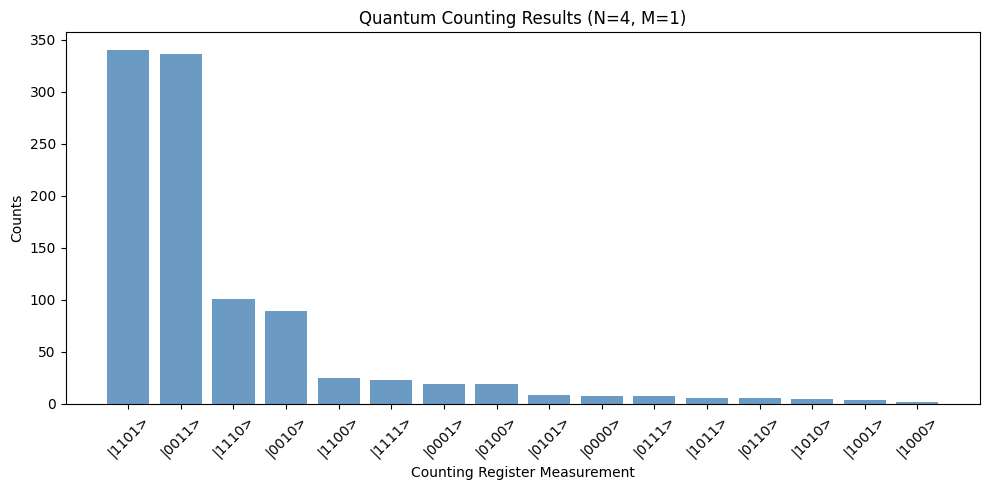

In [5]:
# Visualize counting register results
counting_results = results['counting_register_results']
sorted_results = sorted(counting_results.items(), key=lambda x: x[1], reverse=True)

labels = [f"|{bs}>" for bs, _ in sorted_results]
values = [c for _, c in sorted_results]

plt.figure(figsize=(10, 5))
plt.bar(labels, values, color='steelblue', alpha=0.8)
plt.xlabel('Counting Register Measurement')
plt.ylabel('Counts')
plt.title(f'Quantum Counting Results (N={N}, M={len(marked_states)})')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Example 2: Counting Multiple Marked Items

Count 2 marked items in an 8-element search space ($N = 8$, $n = 3$).

In [6]:
n_counting = 5
n_search = 3
marked_states = [2, 5]
N = 2**n_search

counting_qubits = list(range(n_counting))
search_qubits = list(range(n_counting, n_counting + n_search))

grover = build_grover_matrix(n_search, marked_states)
circ = Circuit()
circ = quantum_counting_circuit(circ, counting_qubits, search_qubits, grover)

device = LocalSimulator()
task = run_quantum_counting(circ, device, shots=2000)

print("Quantum Counting Results (N=8, M=2):")
results = get_quantum_counting_results(
    task, counting_qubits, search_qubits, verbose=True
)

print(f"\nActual M = {len(marked_states)}")
print(f"Estimated M ≈ {results['best_estimate']:.4f}")

Quantum Counting Results (N=8, M=2):
Measurement counts: Counter({'11011101': 184, '00101010': 178, '00101101': 173, '11011010': 167, '11011011': 62, '00101000': 61, '11011110': 59, '00101111': 57, '11011100': 57, '00101001': 55, '11011000': 55, '00101110': 53, '11011001': 47, '00101011': 47, '11011111': 46, '11010101': 44, '00101100': 42, '00110101': 41, '11010010': 37, '00110010': 34, '00110000': 18, '11010000': 18, '00110100': 18, '11010111': 18, '00100101': 17, '00110110': 16, '11010110': 15, '11100101': 15, '11010001': 15, '00100010': 14, '00110001': 13, '11100010': 13, '00110111': 13, '11010100': 12, '11010011': 9, '00110011': 9, '00011010': 9, '00111010': 8, '11100111': 8, '11001001': 7, '11001101': 7, '11001100': 6, '11001010': 6, '00111001': 6, '00100100': 6, '00100001': 6, '11100000': 5, '11100011': 5, '00111111': 5, '01000101': 5, '00100110': 4, '00010101': 4, '11110010': 4, '00010010': 4, '11111010': 4, '11100100': 4, '11001011': 4, '11000010': 4, '00111101': 4, '00011101':

## Example 3: Edge Case — No Marked Items (M = 0)

When no items are marked, the algorithm should estimate $M \approx 0$.

In [7]:
n_counting = 4
n_search = 2
marked_states = []
N = 2**n_search

counting_qubits = list(range(n_counting))
search_qubits = list(range(n_counting, n_counting + n_search))

grover = build_grover_matrix(n_search, marked_states)
circ = Circuit()
circ = quantum_counting_circuit(circ, counting_qubits, search_qubits, grover)

device = LocalSimulator()
task = run_quantum_counting(circ, device, shots=1000)

results = get_quantum_counting_results(
    task, counting_qubits, search_qubits, verbose=True
)

print(f"\nActual M = 0")
print(f"Estimated M ≈ {results['best_estimate']:.4f}")

Measurement counts: Counter({'000011': 255, '000000': 252, '000010': 249, '000001': 244})
Counting register results: {'0000': 1000}
Phase estimates: [0.0]
Estimated item counts: [np.float64(0.0)]
Best estimate of M: 0.0
Search space size N: 4

Actual M = 0
Estimated M ≈ 0.0000


## Example 4: Edge Case — All Items Marked (M = N)

When all items are marked, $M = N$.

In [8]:
n_counting = 4
n_search = 2
N = 2**n_search
marked_states = list(range(N))

counting_qubits = list(range(n_counting))
search_qubits = list(range(n_counting, n_counting + n_search))

grover = build_grover_matrix(n_search, marked_states)
circ = Circuit()
circ = quantum_counting_circuit(circ, counting_qubits, search_qubits, grover)

device = LocalSimulator()
task = run_quantum_counting(circ, device, shots=1000)

results = get_quantum_counting_results(
    task, counting_qubits, search_qubits, verbose=True
)

print(f"\nActual M = {N}")
print(f"Estimated M ≈ {results['best_estimate']:.4f}")

Measurement counts: Counter({'100011': 278, '100010': 251, '100001': 243, '100000': 228})
Counting register results: {'1000': 1000}
Phase estimates: [0.5]
Estimated item counts: [np.float64(4.0)]
Best estimate of M: 4.0
Search space size N: 4

Actual M = 4
Estimated M ≈ 4.0000


## [Optional] Run on a QPU or Managed Simulator

[Include estimated price for running in USD using the [cost tracker](https://docs.aws.amazon.com/braket/latest/developerguide/braket-pricing.html#real-time-cost-tracking).]

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
# from braket.tracking import Tracker

# tracker = Tracker().start()

In [2]:
# from braket.aws import AwsDevice, AwsSession
# import boto3

# boto_session = boto3.Session(region_name="us-east-1")
# aws_session = AwsSession(boto_session=boto_session)

# # Run on managed simulator
# managed_device = AwsDevice(
#     "arn:aws:braket:::device/quantum-simulator/amazon/sv1",
#     aws_session=aws_session
# )
# n_counting = 4
# n_search = 2
# marked_states = [3]
# counting_qubits = list(range(n_counting))
# search_qubits = list(range(n_counting, n_counting + n_search))
# grover = build_grover_matrix(n_search, marked_states)

# circ = Circuit()
# circ = quantum_counting_circuit(circ, counting_qubits, search_qubits, grover)

# task = run_quantum_counting(circ, managed_device, shots=1000)

# results = get_quantum_counting_results(
#     task, counting_qubits, search_qubits, verbose=True
# )
# print(f"\nEstimated M ≈ {results['best_estimate']:.4f}")

In [3]:
# print("Task Summary")
# print(f"{tracker.quantum_tasks_statistics()} \n")
# print(
#     f"Estimated cost to run this example: {tracker.qpu_tasks_cost() + tracker.simulator_tasks_cost():.2f} USD"
# )

Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).